In [1]:
import numpy as np
import torch
from solver import PDE
from models import Sine, Neural_Net, Swish
import matplotlib.pyplot as plt

In [2]:
class Boundary(PDE):
    
    def PDELoss(self, inputs, outputs):
        
        x = outputs[:,0]
        y = outputs[:,1]
        
        # compute gradient for x
        grads_x = self.compute_grad(x,inputs)
        
        dxde, dxdn  = grads_x[:,0], grads_x[:,1]
        
        grads_2x = self.compute_grad(grads_x,inputs)
        
        dx2de2, dx2dn2 = grads_2x[:,0], grads_2x[:,1]
        
        # compute grads for y
        grads_y = self.compute_grad(y,inputs)
        
        dyde, dydn  = grads_y[:,0], grads_y[:,1]
        
        grads_2y = self.compute_grad(grads_y,inputs)
        
        dy2de2, dy2dn2 = grads_2y[:,0], grads_2y[:,1]
        
        # compute cross derivatives
        dx2dedn = self.compute_grad(dxdn, inputs)[:,0]
        dy2dedn = self.compute_grad(dydn, inputs)[:,0]
        
        # formulate pde equations
        x_part = ((dxdn**2 + dydn**2)*dx2de2 -2*(dxde*dxdn + dyde*dydn)*dx2dedn +
                 (dxde**2 + dyde**2)*dx2dn2
                 )
        y_part = ((dxdn**2 + dydn**2)*dy2de2 -2*(dxde*dxdn + dyde*dydn)*dy2dedn +
                 (dxde**2 + dyde**2)*dy2dn2
                 )
        
        
        return {'x conversion':x_part, 
               'y conversion': y_part}
    
pde = Boundary(inputs=('eta','neta'), outputs=('x','y'))

pass


In [3]:
pde.input, pde.output

(('eta', 'neta'), ('x', 'y'))

In [4]:
# define the mesh
eta = np.linspace(0,1,30)
neta = np.linspace(0,1,30)

In [5]:
from mesh import Mesh_Data
mesh = Mesh_Data({'eta':eta, 'neta':neta})
pde.set_mesh(mesh)

In [6]:
# mesh.variable
# mesh.gen_data[:].shape

In [7]:
from geometry import Analytical_Annulus
from boundary import Dirichlet

annulus = Analytical_Annulus(1.,0.6,0.,30,30)


In [8]:
# when eta = 0 and neta has some values
eta_ = np.array([0]) #, neta, 
x = annulus.Xr(eta)
y = annulus.Yr(neta)

branch_1 = Dirichlet({'eta':eta_, 'neta':neta},{'x':x.reshape(-1), 'y':y.reshape(-1)}, name='branch_out_1')
pde.add_boundary(branch_1)

In [9]:
# when eta = 1 and neta has some values
eta_ =np.array([1]) #, neta ,
x = annulus.Xl(eta)
y = annulus.Yl(neta)

branch_2 = Dirichlet({'eta':eta_, 'neta':neta},{'x':x.reshape(-1), 'y':y.reshape(-1)}, name='branch_out_2')
pde.add_boundary(branch_2)

In [10]:
# when eta has some values and neta = 0
#eta, 
neta_ = np.array([0])  
x = annulus.Xb(eta)[::-1]
y = annulus.Yb(neta)[::-1]

inner = Dirichlet({'eta':eta, 'neta':neta_},{'x':x.reshape(-1), 'y':y.reshape(-1)}, name='inner_pipe')
pde.add_boundary(inner)

In [11]:
# when eta has some values and neta = 0
#eta, 
neta_ = np.array([1]) 
x = annulus.Xt(eta)[::-1]
y = annulus.Yt(neta)[::-1]

outer = Dirichlet({'eta':eta, 'neta':neta_},{'x':x.reshape(-1), 'y':y.reshape(-1)}, name='outer_casing')
pde.add_boundary(outer)

In [12]:
activation = Swish(10)
in_dim = len(pde.input)
hid_dim = 512
out_dim = len(pde.output)
lr = 5e-3
layers = 5
net = Neural_Net(in_dim, hid_dim, out_dim, layers, act= activation)

epochs = 100
optimizer = torch.optim.Adam(net.parameters())
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr = lr, pct_start = 0.1, total_steps = epochs)
pde.compile(net, optimizer, scheduler)

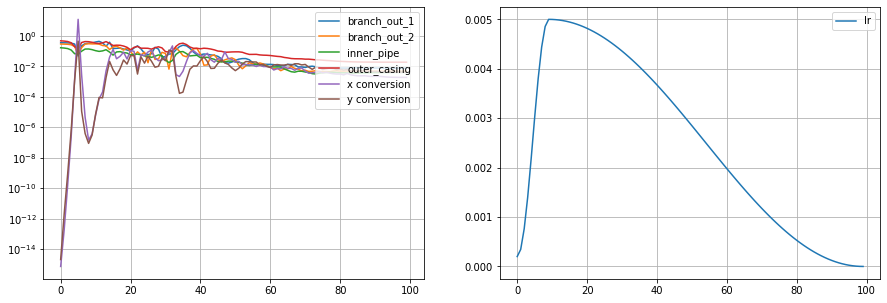

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: aspect is not supported for Axes with xscale=linear, yscale=log
  fig.canvas.print_figure(bytes_io, **kw)


Wall time: 3min 44s


In [13]:
batch_size = 1024
%time hist = pde.solve(epochs, batch_size)

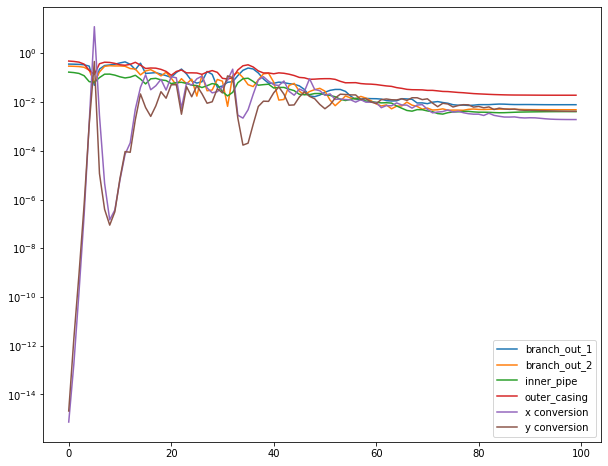

In [14]:
plt.figure(figsize=(10,8))
for key, value in hist.items():
    if key!= 'lr':
        plt.plot(hist[key],label=key)
        plt.legend()
    else:
        pass
    
    plt.yscale('log')

In [15]:
nx = 30
ny=30

x = np.linspace(0,1,nx)
y = np.linspace(0,1,ny)


eval_mesh = Mesh_Data({'x':x, 'y':y})
pred = pde.eval(eval_mesh).numpy()
x, y = pred[:,0].reshape(-1,nx), pred[:,1].reshape(-1,ny)

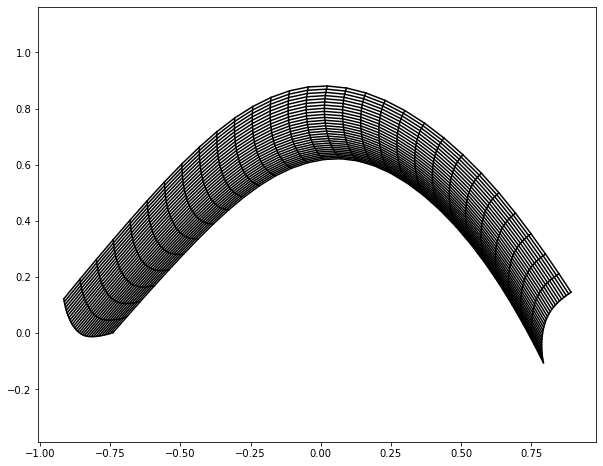

In [16]:
from utils import Plot_Grid
Plot_Grid(x,y,nx,ny)